In [456]:
import time
import json  # for checkpointing
import csv

from collections import Counter

from pathlib import Path

import numpy as np
import scipy.sparse
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors
from tqdm.notebook import trange, tqdm

import pandas as pd

import datetime

import os
from dotenv import load_dotenv, find_dotenv

from timeit import default_timer as timer

load_dotenv(find_dotenv('config.env'))

torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.device_count()
torch.cuda.get_device_name(0)
torch.cuda.is_available()

import sklearn
import sklearn.metrics
import seaborn as sns

In [447]:
np.set_printoptions(precision=0, suppress=True, linewidth=160)

## Foreword about PyTorch Version
This notebook is designed to be used with **PyTorch 1.7.1**. 

However, future versions 
In PyTorch version **1.9.0 and newer** (which is at the time of writing still **unstable**), new parameters such as `batch_first` in `torch.nn.MultiheadAttention` are available, which can make it easier to configure the model creation.

In [2]:
print("Loaded PyTorch Version: {}".format(torch.__version__))

Loaded PyTorch Version: 1.7.1


# PLOT PAGES
### https://seaborn.pydata.org/examples/index.html
### https://seaborn.pydata.org/generated/seaborn.diverging_palette.html
### https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f

In [3]:
diverging_palette_dark = sns.diverging_palette(250, 15, s=75, l=40, n=2, center="dark")
diverging_palette_light = sns.diverging_palette(240, 10, n=2, center="light")
diverging_palette_heatmap = sns.color_palette("icefire", as_cmap=True)

display(diverging_palette_dark)
display(diverging_palette_light)
display(diverging_palette_heatmap)

[(0.20651240887022015, 0.3755393698154809, 0.5856904756194529),
 (0.6565296443848212, 0.21867290090002556, 0.1744737357010414)]

[(0.2564697186166857, 0.4871591358142198, 0.657003695890986),
 (0.8545371341681446, 0.22957019267094914, 0.2762321841840895)]

In [4]:
# PLOT PAGES
# 

# for p in sns.palettes.SEABORN_PALETTES:
#     print(p)
#     sns.set_palette(p)
#     sns.palplot(sns.color_palette())
#     plt.show()

In [5]:
# sns.set_style("ticks")
# sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_style("whitegrid")
# sns.set_style("darkgrid")

sns.set_palette('bright')

In [6]:
def cuda_status_print():
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print("Total:     {:>4.1f} GB".format(round(torch.cuda.get_device_properties(0).total_memory / 1024 ** 3, 1)))
    print('Allocated: {:>4.1f} GB'.format(round(torch.cuda.memory_allocated(0) / 1024 ** 3, 1)))
    print('Cached:    {:>4.1f} GB'.format(round(torch.cuda.memory_reserved(0) / 1024 ** 3, 1)))

In [7]:
!nvidia-smi

Thu Apr 22 12:17:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:B9:00.0 Off |                    0 |
| N/A   28C    P0    48W / 350W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
ticks_tiles_newlined = [
    "1\nman",
    "2\nman",
    "3\nman",
    "4\nman",
    "5\nman",
    "6\nman",
    "7\nman",
    "8\nman",
    "9\nman",
    "1\npin",
    "2\npin",
    "3\npin",
    "4\npin",
    "5\npin",
    "6\npin",
    "7\npin",
    "8\npin",
    "9\npin",
    "1\nsou",
    "2\nsou",
    "3\nsou",
    "4\nsou",
    "5\nsou",
    "6\nsou",
    "7\nsou",
    "8\nsou",
    "9\nsou",
    "\nEast",
    "\nSouth",
    "\nWest",
    "\nNorth",
    "\nHaku",
    "\nHatsu",
    "\nChun"
]

ticks_tiles_oneline = [
    "1 man",
    "2 man",
    "3 man",
    "4 man",
    "5 man",
    "6 man",
    "7 man",
    "8 man",
    "9 man",
    "1 pin",
    "2 pin",
    "3 pin",
    "4 pin",
    "5 pin",
    "6 pin",
    "7 pin",
    "8 pin",
    "9 pin",
    "1 sou",
    "2 sou",
    "3 sou",
    "4 sou",
    "5 sou",
    "6 sou",
    "7 sou",
    "8 sou",
    "9 sou",
    "East",
    "South",
    "West",
    "North",
    "Haku",
    "Hatsu",
    "Chun"
]

In [9]:
##############################################
# PARAMETERS
##############################################
torch.manual_seed(0)
np.random.seed(0)

DEVICE = torch.device("cuda")
EPOCHS = 10
DATASET_CONFIG = 'balanced_test_medium'
SHUFFLE_DATASET = True

cuda_status_print()

Tesla V100-SXM3-32GB
Memory Usage:
Total:     31.7 GB
Allocated:  0.0 GB
Cached:     0.0 GB


In [10]:
class DiscardDataset(torch.utils.data.Dataset):

    def __init__(self, data_path, years: list, n_rows: int = None, phase: int = None, balance_data: bool = False):
        """ If n_rows = None -> get all """ 
        
        # Invalid Parameter Combinations
        if balance_data:
            if not n_rows:
                raise BaseException("`n_rows` must be defined if `balance_data` is True!")
            elif n_rows < 34:
                raise BaseException("Cannot balance data if `n_rows` < 34!")
        
        ALL_YEARS = (2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019)
        invalid_years = set(years) - set(ALL_YEARS)
        if invalid_years:
            raise Exception(f"INVALID YEARS: {invalid_years}")
        
        # Dataset Print
        if n_rows:
            print(f"Loading Dataset with {n_rows:>13,} rows", end=' ')
        else:
            print(f"Loading Dataset with all rows", end=' ')

        if phase in [0, 1, 2]:
            print(f"(Phase {phase})", end=' ')
        else:
            print(f"(All Phases)", end=' ')
            
        print("{:<14}".format("<BALANCED>" if balance_data else '<NOT BALANCED>'), end=' ')
        
        print(years)
            
        temp_matrices = []
        finished = False
        
        # Used when balance_data = False and n_rows != None
        loaded_rows = 0  
        
        # Used when balance_data = True
        class_bins = np.zeros(34)
        baseline_bin_size = n_rows // 34  # The expected size of the smallest bin

        if balance_data:
            paths_load_bar = tqdm(total=baseline_bin_size * 34, unit='rows', position=0)
        else:
            paths_load_bar = tqdm(total=n_rows, unit='rows', position=0)

        for year in years:

            paths = (Path(data_path) / str(year)).iterdir()

            for idx, path in enumerate(paths):

                arr = scipy.sparse.load_npz(path).toarray()

                if phase in [0, 1, 2]:
                    phased_matrices = self.generate_phase_column(arr)
                    arr = phased_matrices[phase]

                temp_matrices.append(arr)

                paths_load_bar.set_postfix(year=year, files_loaded=(idx + 1))  # Update Bar

                if balance_data:
                    
                    class_bins += np.bincount(arr[:, -1], minlength=34)
                    smallest_class_bin = int(np.amin(class_bins))

                    paths_load_bar.n = smallest_class_bin * 34
                    paths_load_bar.refresh()
                    
                    if baseline_bin_size <= smallest_class_bin:
                        finished = True
                        break

                else:
                    paths_load_bar.update(arr.shape[0])
                    
                    if n_rows:
                        loaded_rows += arr.shape[0]
                        if n_rows <= loaded_rows:
                            finished = True
                            break

            if finished:  # Early Stopping
                break
                
        if not finished and nrows:
            raise BaseException("`n_rows` is higher than found rows -- Either lower `n_rows` or include more annual datasets!")
            
        if balance_data:
            matrix = np.concatenate(temp_matrices, axis=0)
            matrix = matrix[np.argsort(matrix[:, -1])]  # Sort rows by last column (the y-value)
            sorted_rows = np.array_split(matrix, np.where(np.diff(matrix[:, -1])!=0)[0]+1)  # Organize rows according to their last column's value into a list
            for i in range(len(sorted_rows)):
                sorted_rows[i] = sorted_rows[i][:baseline_bin_size]  # The balancing action

            final_arr = np.concatenate(sorted_rows, axis=0)
        else:
            final_arr = np.vstack(temp_matrices)

            if n_rows:
                final_arr = final_arr[:n_rows]

        # Finalize tqdm bar
        paths_load_bar.n = final_arr.shape[0]
        paths_load_bar.last_print_n = final_arr.shape[0]
        paths_load_bar.refresh()
        paths_load_bar.close()

        self.x_data = torch.FloatTensor(final_arr[:, :-1])  # Must be Float it seems
        self.y_data = torch.LongTensor(final_arr[:, -1])  # Must be Long it seems

    @staticmethod
    def generate_phase_column(array: np.array) -> np.array:
        # Begin with merging all pools together

        merged_discards = array[:, 238:]  # Discards
        merged_discards = np.sum(merged_discards, axis=1)

        phases = np.zeros([array.shape[0]])  # Early Game
        phases[(24 < merged_discards) & (merged_discards <= 48)] = 1  # Mid Game
        phases[(48 < merged_discards)] = 2  # End Game

        return array[(phases == 0)], array[(phases == 1)], array[(phases == 2)]

    def __len__(self):
        return self.x_data.shape[0]

    def __getitem__(self, idx):
        return {
            'X': self.x_data[idx],
            'y': self.y_data[idx]
        }

# DATASET

In [11]:
# Load from configurations
ds_configs = pd.read_csv('Dataset Configurations.csv', index_col='dataset_name')
selected_config = ds_configs.loc[DATASET_CONFIG]
selected_config

train_size          340000
validation_size       1000
test_size             1000
batch                   32
phases                  -1
years_training        1100
years_validation        10
years_testing            1
balanced_data          110
Name: balanced_test_medium, dtype: int64

In [12]:
def get_years(code: str) -> list:
    code = int(f"0b{code:0>11}", 2)
    found_years = []
    for i in range(11):
        if (code >> i) & 1:
            found_years.append(2019 - i)
    found_years.reverse()
    return found_years

In [13]:
def get_balanced_data_options(code: str):
    results = [False, False, False]
    code = int(f"0b{code:0>11}", 2)
    results[0] = code & 0b100 != 0
    results[1] = code & 0b010 != 0
    results[2] = code & 0b001 != 0
    return results

In [14]:
print("\nLOADING DATASETS:\n")

# Setup of Parameters
DATASET_PATH = Path(os.environ.get('DISCARD_DATASET'))  # Get path
BATCH_SIZE = int(selected_config['batch'])  # We must cast it or else it will crash
BALANCED_TRAINING, BALANCED_VALIDATION, BALANCED_TEST = get_balanced_data_options(selected_config['balanced_data'])  # 3 boolean values
PHASES = selected_config['phases']

# Training Dataset
train_dataset = DiscardDataset(DATASET_PATH,
                               n_rows=selected_config['train_size'],
                               years=get_years(selected_config['years_training']),
                               phase=PHASES,
                               balance_data=BALANCED_TRAINING
                              )

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_DATASET)

# Validation Dataset
validation_dataset = DiscardDataset(DATASET_PATH,
                                    n_rows=selected_config['validation_size'],
                                    years=get_years(selected_config['years_validation']),
                                    phase=PHASES,
                                    balance_data=BALANCED_VALIDATION
                                   )

validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_DATASET)

# Test Dataset
test_dataset = DiscardDataset(DATASET_PATH, 
                              n_rows=selected_config['test_size'], 
                              years=get_years(selected_config['years_testing']),
                              phase=PHASES,
                              balance_data=BALANCED_TEST
                             )

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=SHUFFLE_DATASET)


LOADING DATASETS:

Loading Dataset with       340,000 rows (All Phases) <BALANCED>     [2016, 2017]


  0%|          | 0/340000 [00:00<?, ?rows/s]

Loading Dataset with         1,000 rows (All Phases) <BALANCED>     [2018]


  0%|          | 0/986 [00:00<?, ?rows/s]

Loading Dataset with         1,000 rows (All Phases) <NOT BALANCED> [2019]


  0%|          | 0/1000 [00:00<?, ?rows/s]

In [15]:
cuda_status_print()

Tesla V100-SXM3-32GB
Memory Usage:
Total:     31.7 GB
Allocated:  0.0 GB
Cached:     0.0 GB


## Invalid Data Checker
On rare occasions, some training cases X may be invalid constructed (e.g. the whole tensor is added 1).

How these corruptions occur is a mystery. If corrupted indices are found, redo the dataset loading!

In [16]:
def count_corrupted_cases(dataset):
    """ Return indices of corrupted X datas. """
    return torch.nonzero(torch.sum(dataset.x_data[:, 68:102], dim=1) > 14).flatten().tolist()

corrupt_datasets = [count_corrupted_cases(train_dataset), count_corrupted_cases(validation_dataset), count_corrupted_cases(test_dataset)]
print(f"""Corrupted Dataset Indices:
    - Training Dataset:   {corrupt_datasets[0]}
    - Validation Dataset: {corrupt_datasets[1]}
    - Testing Dataset:    {corrupt_datasets[2]}
""")

assert len(corrupt_datasets[0]) == 0 and len(corrupt_datasets[1]) == 0 and len(corrupt_datasets[2]) == 0

Corrupted Dataset Indices:
    - Training Dataset:   []
    - Validation Dataset: []
    - Testing Dataset:    []



## Number of Valid Classes Distribution

,n_valid_classes,training_count,validation_count,testing_count
0,0,0,0,0
1,1,0,0,0
2,2,55,0,0
3,3,1086,0,7
4,4,3107,2,16
5,5,4710,12,17
6,6,9538,27,32
7,7,15860,44,46
8,8,21741,55,70
9,9,38451,102,84


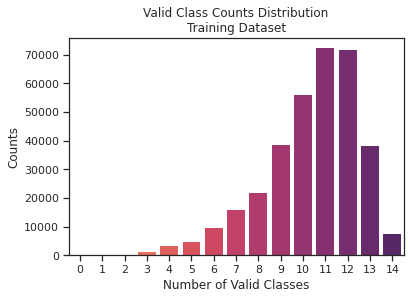

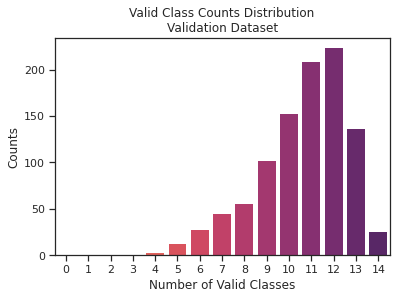

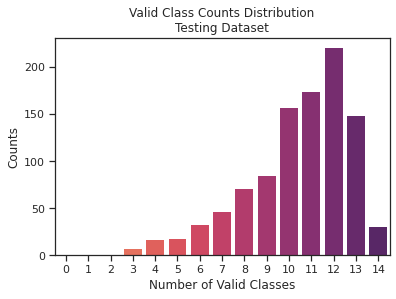

In [17]:
def get_valid_counts(dataset, column_name):
    n_valid, frequency   = np.unique(torch.sum(dataset.x_data[:, 68:102].bool(), dim=1).numpy(), return_counts=True)
    
    data = pd.DataFrame({
        "n_valid_classes": n_valid,
        column_name: frequency
    })
    data = data.set_index('n_valid_classes')
    data = data.reindex(np.arange(0, 14 + 1, dtype=int), fill_value=0)
    
    return data


def display_valid_class_distribution(df, count_column, title):
    # https://seaborn.pydata.org/generated/seaborn.barplot.html#seaborn.barplot
    # http://alanpryorjr.com/visualizations/seaborn/countplot/countplot/
    sns.set(style="ticks", font_scale=1)
    ax = sns.barplot(data=df,
                     x="n_valid_classes", 
                     y=count_column,
                     palette="flare",
                     saturation=10,
                     edgecolor=(0,0,0),
                     linewidth=0,)

    plt.title(title)
    plt.xlabel('Number of Valid Classes')
    plt.ylabel('Counts')
    
    plt.xticks(range(0, 15))

    plt.show()

    
inversion_count_df = pd.concat([
    get_valid_counts(train_dataset      , "training_count"),
    get_valid_counts(validation_dataset , "validation_count"),
    get_valid_counts(test_dataset       , "testing_count")], 
    axis=1).reset_index()

display(inversion_count_df)

display_valid_class_distribution(inversion_count_df, "training_count", 'Valid Class Counts Distribution\nTraining Dataset')
display_valid_class_distribution(inversion_count_df, "validation_count", 'Valid Class Counts Distribution\nValidation Dataset')
display_valid_class_distribution(inversion_count_df, "testing_count", 'Valid Class Counts Distribution\nTesting Dataset')

## Dataset Class Distribution

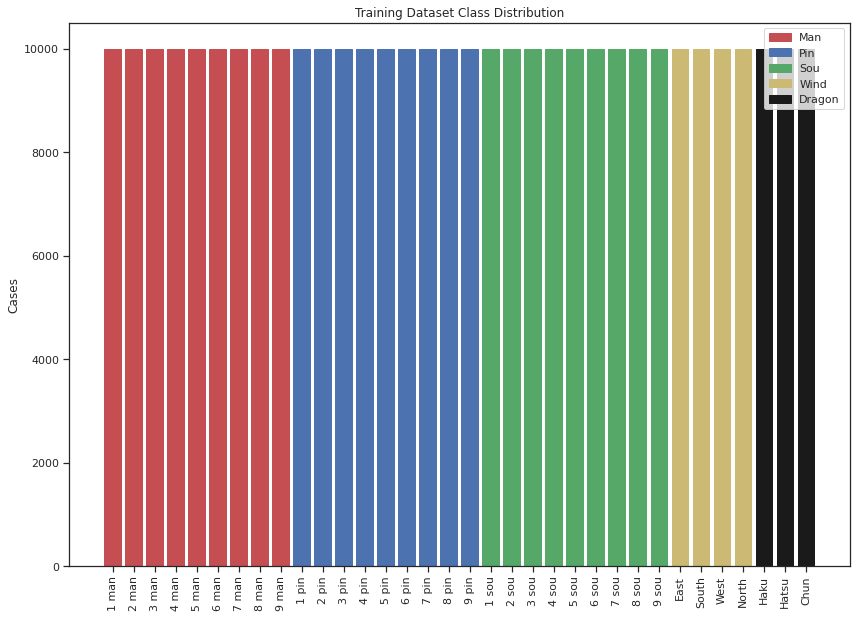

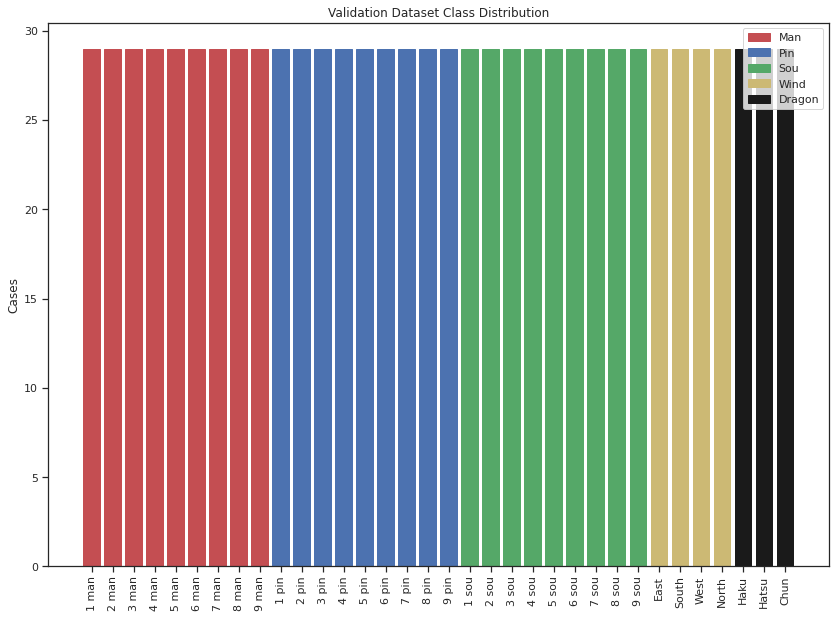

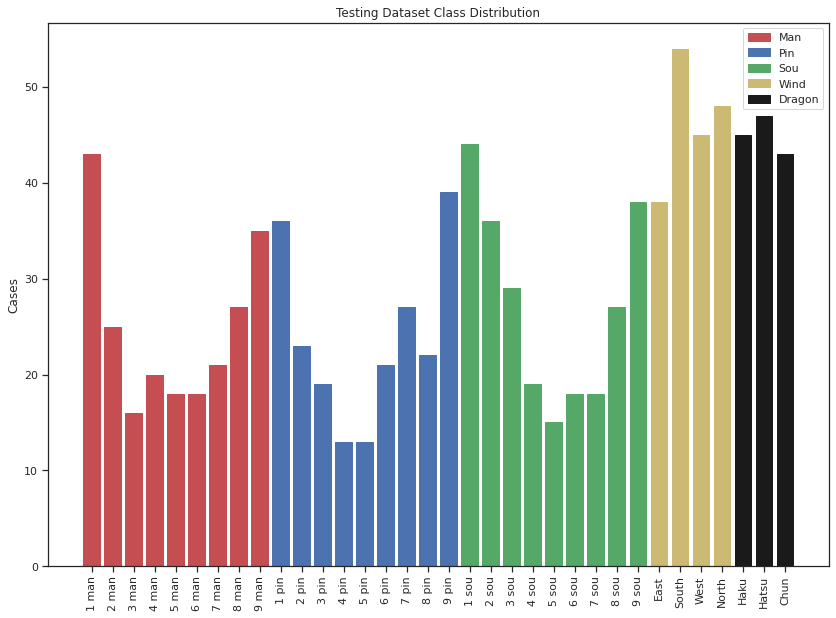

In [18]:
def generate_dataset_class_distribution(Y, title: str, horizontal=False):
    
    keys, counts = np.unique(Y, return_counts=True)
    fig = plt.figure(figsize=(14, 10))

    bar_list = None
    if not horizontal:
        bar_list = plt.bar(keys, counts)
        plt.xticks(range(34), ticks_tiles_oneline, rotation=90)
        plt.ylabel("Cases")
    else:
        bar_list = plt.barh(keys, counts)
        plt.yticks(range(34), ticks_tiles_oneline, rotation=0)
        plt.xlabel("Cases")

    for i in range(0, 9):
        bar_list[i].set_color('r')

    for i in range(9, 18):
        bar_list[i].set_color('b')

    for i in range(18, 27):
        bar_list[i].set_color('g')

    for i in range(27, 31):
        bar_list[i].set_color('y')

    for i in range(31, 34):
        bar_list[i].set_color('k')

    ax = plt.gca()
    legend_man = mpatches.Patch(color='r', label='Man')
    legend_pin = mpatches.Patch(color='b', label='Pin')
    legend_sou = mpatches.Patch(color='g', label='Sou')
    legend_wind = mpatches.Patch(color='y', label='Wind')
    legend_dragons = mpatches.Patch(color='k', label='Dragon')

    plt.title(title)
    plt.legend(handles=[legend_man, legend_pin, legend_sou, legend_wind, legend_dragons])

    plt.show()

generate_dataset_class_distribution(train_dataset.y_data, "Training Dataset Class Distribution", horizontal=False)
generate_dataset_class_distribution(validation_dataset.y_data, "Validation Dataset Class Distribution", horizontal=False)
generate_dataset_class_distribution(test_dataset.y_data, "Testing Dataset Class Distribution", horizontal=False)

# Model Creation

## Basic Network

In [19]:
class AttentiveNet(torch.nn.Module):
    """ Multihead Attention Layer into simple feed-forward net. """

    def __init__(self):
        super(AttentiveNet, self).__init__()
        
        self.name = "AttentiveNet"
        
        self.mha1 = torch.nn.MultiheadAttention(embed_dim=374, 
                                                num_heads=34,  # 1, 11, or 34 are doable
                                                dropout=0.0,   # Default: 0.0.
                                                add_zero_attn=True,  # Default: False
                                               )

        self.fc1 = torch.nn.Linear(11 * 34, 1028)
        self.fc2 = torch.nn.Linear(1028, 512)
        self.fc3 = torch.nn.Linear(512, 256)
        self.fc4 = torch.nn.Linear(256, 128)
        self.fc5 = torch.nn.Linear(128, 34)
        
        self.relu_1 = torch.nn.LeakyReLU()
        self.relu_2 = torch.nn.LeakyReLU()
        self.relu_3 = torch.nn.LeakyReLU()
        self.relu_4 = torch.nn.LeakyReLU()

    def forward(self, x):
        
        batch_size = x.shape[0]
        x = x.reshape(1, batch_size, 374)  #  => x.shape[0] = Batch Size
        attn_output, attn_output_weights = self.mha1(query=x, key=x, value=x, need_weights=False)  # attn_output_weights = None, if need_weights=False
        x = (x * attn_output).reshape(batch_size, 374)

        x = self.fc1(x)
        x = self.relu_1(x)
        
        x = self.fc2(x)
        x = self.relu_2(x)
        
        x = self.fc3(x)
        x = self.relu_3(x)
        
        x = self.fc4(x)
        x = self.relu_4(x)
        
        x = self.fc5(x)

        return x

    
model = AttentiveNet().to(DEVICE)
criterion = torch.nn.CrossEntropyLoss().to(DEVICE)  # Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

loaded_epoch = 0

model

AttentiveNet(
  (mha1): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=374, out_features=374, bias=True)
  )
  (fc1): Linear(in_features=374, out_features=1028, bias=True)
  (fc2): Linear(in_features=1028, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=34, bias=True)
  (relu_1): LeakyReLU(negative_slope=0.01)
  (relu_2): LeakyReLU(negative_slope=0.01)
  (relu_3): LeakyReLU(negative_slope=0.01)
  (relu_4): LeakyReLU(negative_slope=0.01)
)

In [20]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
trainable_params

1641958

In [342]:
import inspect

inspect.getmembers(model.mha1)

[('T_destination', ~T_destination),
 ('__annotations__',
  {'bias_k': typing.Union[torch.Tensor, NoneType],
   'bias_v': typing.Union[torch.Tensor, NoneType]}),
 ('__call__',
  <bound method Module._call_impl of MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=374, out_features=374, bias=True)
  )>),
 ('__class__', torch.nn.modules.activation.MultiheadAttention),
 ('__delattr__',
  <bound method Module.__delattr__ of MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=374, out_features=374, bias=True)
  )>),
 ('__dict__',
  {'training': False,
   '_parameters': OrderedDict([('in_proj_weight',
                 Parameter containing:
                 tensor([[ 0.0100,  0.0417,  0.0333,  ...,  0.0474,  0.0178, -0.0320],
                         [ 0.0386,  0.0326, -0.0010,  ...,  0.0093, -0.0413, -0.0452],
                         [ 0.0299,  0.0014,  0.0066,  ...,  0.0274, -0.0489, -0.0140],
                         ...,
                         [-0.0678, -0.0615,

In [75]:
model.mha1._parameters['in_proj_weight'][0, 0:34]

tensor([ 0.0100,  0.0417,  0.0333,  0.0116,  0.0602,  0.0420,  0.0292, -0.0301,
        -0.0214, -0.0484, -0.0136,  0.0618, -0.0294, -0.0439,  0.0531,  0.0632,
        -0.0322,  0.0463, -0.0622,  0.0060,  0.0459,  0.0110,  0.0207, -0.0044,
        -0.0336,  0.0467,  0.0341,  0.0492,  0.0626,  0.0342,  0.0615, -0.0480,
        -0.0183, -0.0226], device='cuda:0', grad_fn=<SliceBackward>)

# Testing Multiheadattention

In [350]:
mha_0 = torch.nn.MultiheadAttention(embed_dim=374, 
                                    num_heads=34,  # 1, 11, or 34 are doable
                                    dropout=0.0,   # Default: 0.0.
                                    add_zero_attn=False,  # Default: False
                                   ).to(DEVICE)

In [351]:
mha_0._parameters['in_proj_weight'].shape

torch.Size([1122, 374])

In [352]:
mha_0._parameters['in_proj_bias'].shape

torch.Size([1122])

In [403]:
random_x_case = x[0, 2]
random_x_case.reshape(11, 34)

tensor([[   0.,    0.,    2.,    0.,    0.,    3.,   25.,   25.,   25.,   25.,
            0.,    0.,    1.,    1., -128., -128., -128., -128., -128., -128.,
         -128., -128., -128., -128., -128., -128., -128., -128., -128., -128.,
         -128., -128., -128., -128.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.],
        [   0.,    0.,    1.,    1.,    2.,    0.,    0.,    0.,    0.,    0.,
            2.,    2.,    0.,    1.,    0.,    0.,    0.,    0.,    0.,    2.,
            0.,    0.,    1.,    1.,    1.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,  

In [47]:
LOAD_FOLDER = None  # Change this to None do NOT want to load anything, otherwise a string to designated model-folder

# TO LOAD OR NOT LOAD
if LOAD_FOLDER:
    CHECKPOINT_PATH = Path('model_checkpoints') / LOAD_FOLDER
    DESCRIPTION_PATH = CHECKPOINT_PATH / 'description.json'
    SUMMARY_PATH = CHECKPOINT_PATH / 'summary.csv'
    INVERSION_STATS_PATH = CHECKPOINT_PATH / 'inversions.csv'
    INVERSION_COUNTS_PATH = CHECKPOINT_PATH / 'inversions_counts.csv'
    HEATMAP_PATH = CHECKPOINT_PATH / 'heatmap.csv'

    last_epoch_file = sorted([c for c in CHECKPOINT_PATH.iterdir() if c.suffix == '.pt'])[-1]
    loaded_checkpoint = torch.load(last_epoch_file)
    print('Loaded Epoch', loaded_checkpoint['epoch'])

    model.load_state_dict(loaded_checkpoint['model_state'])
    optimizer.load_state_dict(loaded_checkpoint['optimizer_state'])
    loaded_epoch = loaded_checkpoint['epoch']

else:
    # Create Model Checkpoint Folder
    timestamp_string = time.strftime('%Y-%m-%d_%H-%M', time.localtime(time.time()))
    CHECKPOINT_PATH = Path('model_checkpoints') / f"{timestamp_string}_{model.name}"
    CHECKPOINT_PATH.mkdir()

    DESCRIPTION_PATH = CHECKPOINT_PATH / 'description.json'
    SUMMARY_PATH = CHECKPOINT_PATH / 'summary.csv'
    INVERSION_STATS_PATH = CHECKPOINT_PATH / 'inversions.csv'
    INVERSION_COUNTS_PATH = CHECKPOINT_PATH / 'inversions_counts.csv'
    HEATMAP_PATH = CHECKPOINT_PATH / 'heatmap.csv'

    model_desc_json = {
        'model_name': model.name,
        'model_description': repr(model),
        'dataset_config': repr(selected_config)
    }

    with open(DESCRIPTION_PATH, 'w') as outfile:
        json.dump(model_desc_json, outfile)

    with open(SUMMARY_PATH, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", 
                         "train_loss", 
                         "train_acc", 
                         "train_average_valid_weight_sum", 
                         "train_average_weight_per_valid_class", 
                         "train_average_weight_per_invalid_class", 
                         "val_loss", 
                         "val_acc", 
                         "val_average_valid_weight_sum", 
                         "val_average_weight_per_valid_class", 
                         "val_average_weight_per_invalid_class",
                         "time_elapsed"])
    
    with open(INVERSION_STATS_PATH, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["mode",
                         "epoch",
                         "n_valid",
                         "min", 
                         "max", 
                         "mean", 
                         "median",])
        
    inversion_count_df.to_csv(INVERSION_COUNTS_PATH, index=False)
    
    with open(HEATMAP_PATH, 'w', newline='') as file:
        writer = csv.writer(file)
        heatmap_fieldnames = ["mode", "epoch", "n_valid"] + [f'h_{i}' for i in range(34)]
        writer.writerow(heatmap_fieldnames)

Loaded Epoch 9


# TRAINING & VALIDATION

In [23]:
def seconds_to_hhmmss(s):
    seconds = s
    minutes = seconds // 60
    hours = minutes // 60
    return "%02d:%02d:%02d" % (hours, minutes % 60, seconds % 60)

In [24]:
def get_discard_weight_sum_metrics(hands, logits):
    """ 
    Calculates different weight sum metrics.
    Note: TensorShape of both params must be equal!

    Args:
        hands (Tensor): POV hands as tensor. Expected shape: [b, 34] where b is batch size
        logits (Tensor): logits as tensor. Expected shape: [b, 34] where b is batch size

    Returns:
        tuple(Float, Float): 
            0. First value is the average weight sum of valid discards.
            1. Second value is the average weight sum of valid discards divided by number of valid discard classes.
    """
    
    class_distributions = F.softmax(logits, dim=1)  # Convert logits into distribution that sums to 1
    masked = hands.bool() * class_distributions  # Mask tensorwise, where invalid classes => 0.
    num_valid_classes = torch.sum(hands.bool(), dim=1)
    sum_valid_weight_sum = torch.sum(masked, dim=1)  # Sum() each row

    # Batch Averages
    avg_batch_weight_sum = torch.mean(sum_valid_weight_sum).item()
    avg_batch_weight_sum_per_class = torch.mean(sum_valid_weight_sum / num_valid_classes).item()
    avg_batch_weight_sum_per_class_invalid = torch.mean((1 - sum_valid_weight_sum) / (34 - num_valid_classes)).item()
    
    return avg_batch_weight_sum, avg_batch_weight_sum_per_class, avg_batch_weight_sum_per_class_invalid

In [25]:
def generate_sorted_binary_valid_class_tensors(hands, logits):
    return torch.gather(hands.bool(), dim=1, index=torch.argsort(logits, dim=1, descending=True))

In [26]:
def generate_inversion_rows(mode: str, epoch: int, n_valids: np.array, binary_valids: np.array) -> list:
    
    assert mode == 'training' or mode == 'validation', f"ILLEGAL MODE: {mode}"
    
    # Count Inversions Formula
    # all_inversion_counts = torch.sum(
    #    torch.cumsum(binary_valids.bitwise_not(), dim=1) * binary_valids, 
    #    dim=1
    # )
    
    # Conversion: [Tensor -> np.array] Reason: Removes overhead from GPU memory TODO: NO NEED AS WE WILL DO THE CONVERSION OUTSIDE
#     n_valids = n_valids.cpu().numpy()  
#     binary_valids = binary_valids.cpu().numpy()
    
    all_inversion_counts = (np.bitwise_not(binary_valids).cumsum(axis=1) * binary_valids).sum(axis=1)  # Count inversions of binary arrays
    
    inversion_dict_list = []
    for n_valid in range(1, 15):
        mask = n_valids == n_valid
        if True in mask:  # False if mask does not find matching tensors
            arr = all_inversion_counts[mask]  # Masked inversion counts tensor      
            inversion_dict_list.append({
                 "mode": 0 if mode == 'training' else 1,
                 "epoch": epoch,
                 "n_valid": n_valid,
                 "min": np.amin(arr), 
                 "max": np.amax(arr), 
                 "mean": np.mean(arr), 
                 "median": np.median(arr),
            })
        else:
            inversion_dict_list.append({
                 "mode": 0 if mode == 'training' else 1,
                 "epoch": epoch,
                 "n_valid": n_valid,
                 "min": np.NAN, 
                 "max": np.NAN, 
                 "mean": np.NAN, 
                 "median": np.NAN,
            })

    return inversion_dict_list

In [29]:
def generate_heatmap_rows(mode: str, epoch: int, n_valids: np.array, binary_valids: np.array) -> np.array:
    
    assert mode == 'training' or mode == 'validation', f"ILLEGAL MODE: {mode}"
    
    # Heat-values setup
    heat_array = np.full((14, 34), fill_value=np.NAN)  # 2D np.array
    for n_valid in range(1, 15):
        mask = n_valids == n_valid
        if True in mask:  # False if mask does not find matching tensors
            masked_arrays = binary_valids[mask, :]
            heat_array[n_valid - 1] = np.sum(masked_arrays, axis=0) / masked_arrays.shape[0]  # Get average frequency of valid bit for each position
    
    # Metadata columns
    mode_column = np.zeros((14, 1), dtype=np.uint8) if mode == 'training' else np.ones((14, 1), dtype=np.uint8)
    epoch_column = np.full((14, 1), fill_value=epoch)
    n_valid_column = np.arange(start=1, stop=15, dtype=np.uint8).reshape(14, 1)
    
    return np.concatenate((mode_column, epoch_column, n_valid_column, heat_array), axis=1)

In [30]:
if loaded_epoch != 0:
    loaded_epoch += 1  # If epoch was loaded

# Progress Bars
mq = trange(EPOCHS, desc='EPOCH', unit='epoch', initial=loaded_epoch)
tq = trange(len(train_loader), desc=f'TRAINING', unit='batch')
vq = trange(len(validation_loader), desc=f'VALIDATION', unit='batch')


for epoch in range(loaded_epoch, EPOCHS):
    
    torch.manual_seed(epoch)
    start_timer = timer()  # Start timer
    
    ##############################################
    # TRAINING
    ##############################################
    sum_epoch_loss = 0.0
    sum_epoch_acc = 0.0
    sum_valid_discard_weight_sum = 0.0
    sum_valid_discard_weight_sum_per_tile = 0.0
    sum_invalid_discard_weight_sum_per_tile = 0.0

    binary_valid_tensors = []  # For Inversion & Heatmap calculation
    
    model.train()
    for batch_idx, batch in enumerate(train_loader):
        X = batch['X'].to(DEVICE)
        y = batch['y'].to(DEVICE)

        optimizer.zero_grad()

        outputs = model(X)  # Outputs float values for each class (do softmax on `outputs` to get distribution)
        
        # Loss Calculation
        loss = criterion(outputs, y)  # avg loss in batch -> No need for softmax if criterion = Cross Entropy Loss
        sum_epoch_loss += loss.item()

        # Accuracy Calculation
        predictions = torch.argmax(outputs, dim=1)
        num_correct_predictions = torch.sum(torch.eq(predictions, y)).item()
        batch_acc = num_correct_predictions / y.shape[0]  # y.shape[0] = batch_size
        sum_epoch_acc += batch_acc
        
        # Calculate Valid/Invalid Discards weights
        avg_vwsum, avg_vwsum_per_class, avg_iwsum_per_class = get_discard_weight_sum_metrics(hands=X[:, 68:102], logits=outputs)
        sum_valid_discard_weight_sum += avg_vwsum  # Mean() each row into final `valid weight average`
        sum_valid_discard_weight_sum_per_tile += avg_vwsum_per_class
        sum_invalid_discard_weight_sum_per_tile += avg_iwsum_per_class
        
        # Calculate Number of Inversios
        binary_valid_tensors.append(generate_sorted_binary_valid_class_tensors(hands=X[:, 68:102], logits=outputs))

        # Batch Clean-up
        loss.backward()  # compute gradients
        optimizer.step()  # update weights
        
        tq.update(1)
    
    tq.refresh()
    time.sleep(0.1)
    
    # Training Summary Calculations
    avg_acc_train = sum_epoch_acc / len(train_loader)  # average accuracy
    avg_loss_train = sum_epoch_loss / len(train_loader)  # average loss
    avg_valid_discard_weight_sum_train = sum_valid_discard_weight_sum / len(train_loader)  # average valid weight
    sum_valid_discard_weight_sum_per_tile_train = sum_valid_discard_weight_sum_per_tile / len(train_loader)
    sum_invalid_discard_weight_sum_per_tile_train = sum_invalid_discard_weight_sum_per_tile / len(train_loader)
    
    ### INVERSION & HEATMAP Calculation
    binary_valid_tensors = torch.cat(binary_valid_tensors).cpu().numpy()  # Nested 2D PyTorch Tensors => Single 2D NumPy Array
    n_valid_classes = binary_valid_tensors.sum(axis=1)
    inversion_rows_train = generate_inversion_rows('training', epoch, n_valid_classes, binary_valid_tensors)
    heatmap_rows_train = generate_heatmap_rows('training', epoch, n_valid_classes, binary_valid_tensors)
        
    ##############################################
    # VALIDATION
    ##############################################
    sum_epoch_loss = 0.0
    sum_epoch_acc = 0.0
    sum_valid_discard_weight_sum = 0.0
    sum_valid_discard_weight_sum_per_tile = 0.0
    sum_invalid_discard_weight_sum_per_tile = 0.0
    
    binary_valid_tensors = []  # For Inversion & Heatmap calculation

    model.eval()
    for batch_idx, batch in enumerate(validation_loader):
        X = batch['X'].to(DEVICE)
        y = batch['y'].to(DEVICE)

        # optimizer.zero_grad()  # TODO: Needed?

        with torch.no_grad():  # Disables tracking of gradient
            outputs = model(X)
            
        # Loss Calculation
        loss = criterion(outputs, y)  # avg loss in batch
        sum_epoch_loss += loss.item()

        # Accuracy Calculation
        predictions = torch.argmax(outputs, dim=1)
        num_correct_predictions = torch.sum(torch.eq(predictions, y)).item()
        batch_acc = num_correct_predictions / y.shape[0]  # y.shape[0] = batch_size
        sum_epoch_acc += batch_acc
        
        # Calculate Valid/Invalid Discards weights
        avg_vwsum, avg_vwsum_per_class, avg_iwsum_per_class = get_discard_weight_sum_metrics(hands=X[:, 68:102], logits=outputs)
        sum_valid_discard_weight_sum += avg_vwsum  # Mean() each row into final `valid weight average`
        sum_valid_discard_weight_sum_per_tile += avg_vwsum_per_class
        sum_invalid_discard_weight_sum_per_tile += avg_iwsum_per_class
        
        # Calculate Number of Inversions
        binary_valid_tensors.append(generate_sorted_binary_valid_class_tensors(hands=X[:, 68:102], logits=outputs))
        
        vq.update(1)
    
    vq.refresh()
    time.sleep(0.1)
    
    # Training Summary Calculations
    avg_acc_val = sum_epoch_acc / len(validation_loader)  # average accuracy
    avg_loss_val = sum_epoch_loss / len(validation_loader)  # average loss
    avg_valid_discard_weight_sum_val = sum_valid_discard_weight_sum / len(validation_loader)  # average valid weight
    sum_valid_discard_weight_sum_per_tile_val = sum_valid_discard_weight_sum_per_tile / len(validation_loader)
    sum_invalid_discard_weight_sum_per_tile_val = sum_invalid_discard_weight_sum_per_tile / len(validation_loader)
    
    ### INVERSION & HEATMAP Calculation
    binary_valid_tensors = torch.cat(binary_valid_tensors).cpu().numpy()  # Nested 2D PyTorch Tensors => Single 2D NumPy Array
    n_valid_classes = binary_valid_tensors.sum(axis=1)
    inversion_rows_val = generate_inversion_rows('validation', epoch, n_valid_classes, binary_valid_tensors)
    heatmap_rows_val = generate_heatmap_rows('validation', epoch, n_valid_classes, binary_valid_tensors)
    
    ##############################################
    # EPOCH CLEAN-UP
    ##############################################
    elapsed_time = timer() - start_timer  # End Timer
    
    # Print Epoch Summary
    print('EPOCH {:>2}  |  TRAIN: loss={:.3f}, acc={:5.3f}, vwsum={:5.3f} -> valid/invalid={:5.3f}/{:5.3f} |  VALIDATION: loss={:.3f}, acc={:5.3f}, vwsum={:5.3f} -> valid/invalid={:5.3f}/{:5.3f}  | TIME ELAPSED: {}'
          .format(epoch,
                  avg_loss_train, 
                  avg_acc_train,
                  avg_valid_discard_weight_sum_train,
                  sum_valid_discard_weight_sum_per_tile_train,
                  sum_invalid_discard_weight_sum_per_tile_train,
                  avg_loss_val, 
                  avg_acc_val,
                  avg_valid_discard_weight_sum_val,
                  sum_valid_discard_weight_sum_per_tile_val,
                  sum_invalid_discard_weight_sum_per_tile_val,
                  seconds_to_hhmmss(elapsed_time),
                 ))
    
    # Save Epoch Summary to csv
    with open(SUMMARY_PATH, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            epoch, 
            avg_loss_train,
            avg_acc_train,
            avg_valid_discard_weight_sum_train,
            sum_valid_discard_weight_sum_per_tile_train,
            sum_invalid_discard_weight_sum_per_tile_train,
            avg_loss_val,
            avg_acc_val,
            avg_valid_discard_weight_sum_val,
            sum_valid_discard_weight_sum_per_tile_val,
            sum_invalid_discard_weight_sum_per_tile_val,
            seconds_to_hhmmss(elapsed_time)
        ])
        
    with open(INVERSION_STATS_PATH, 'a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=["mode","epoch","n_valid","min", "max", "mean", "median",])
        writer.writerows(inversion_rows_train + inversion_rows_val)
    
    # Heatmap to .csv
    heatmap_combined_np = np.concatenate((heatmap_rows_train, heatmap_rows_val), axis=0)
    heatmap_df = pd.DataFrame(heatmap_combined_np)
    heatmap_df.to_csv(HEATMAP_PATH, mode='a', header=False, index=False, na_rep='NaN')
        
    # Checkpoint Creation
    training_checkpoint = {
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'epoch': epoch,
    }

    destination = CHECKPOINT_PATH / (f'epoch-{epoch:03}.pt')
    torch.save(training_checkpoint, destination)
    
    # Progress Bar Clean-up
    mq.update(1)
    tq.reset()
    vq.reset()

EPOCH:   0%|          | 0/10 [00:00<?, ?epoch/s]

TRAINING:   0%|          | 0/10625 [00:00<?, ?batch/s]

VALIDATION:   0%|          | 0/31 [00:00<?, ?batch/s]

EPOCH  0  |  TRAIN: loss=3.464, acc=0.044, vwsum=0.318 -> valid/invalid=0.031/0.029 |  VALIDATION: loss=3.477, acc=0.042, vwsum=0.325 -> valid/invalid=0.031/0.029  | TIME ELAPSED: 00:00:36
EPOCH  1  |  TRAIN: loss=3.461, acc=0.044, vwsum=0.319 -> valid/invalid=0.031/0.029 |  VALIDATION: loss=3.475, acc=0.033, vwsum=0.325 -> valid/invalid=0.031/0.029  | TIME ELAPSED: 00:00:36
EPOCH  2  |  TRAIN: loss=3.460, acc=0.044, vwsum=0.319 -> valid/invalid=0.031/0.029 |  VALIDATION: loss=3.477, acc=0.036, vwsum=0.331 -> valid/invalid=0.031/0.029  | TIME ELAPSED: 00:00:36
EPOCH  3  |  TRAIN: loss=3.459, acc=0.044, vwsum=0.319 -> valid/invalid=0.031/0.029 |  VALIDATION: loss=3.477, acc=0.040, vwsum=0.326 -> valid/invalid=0.031/0.029  | TIME ELAPSED: 00:00:36


KeyboardInterrupt: 

# Model TESTING

### Load Model for Testing

In [ ]:
LOAD_MODEL_FOLDER = "first_mha_2021-04-20"
LOAD_EPOCH_NUMBER = None  # If None, select epoch with lowest val_loss

CHECKPOINT_PATH = Path('model_checkpoints') / LOAD_MODEL_FOLDER
DESCRIPTION_PATH = CHECKPOINT_PATH / 'description.json'
SUMMARY_PATH = CHECKPOINT_PATH / 'summary.csv'
INVERSION_STATS_PATH = CHECKPOINT_PATH / 'inversions.csv'
INVERSION_COUNTS_PATH = CHECKPOINT_PATH / 'inversions_counts.csv'
HEATMAP_PATH = CHECKPOINT_PATH / 'heatmap.csv'

loaded_checkpoint = None
if not LOAD_EPOCH_NUMBER:
    summary_df = pd.read_csv(SUMMARY_PATH).dropna()
    lowest_val_loss_id = summary_df['val_loss'].idxmin()
    loaded_checkpoint = torch.load(CHECKPOINT_PATH / f"epoch-{lowest_val_loss_id:03}.pt")
else:
    loaded_checkpoint = torch.load(CHECKPOINT_PATH / f"epoch-{LOAD_EPOCH_NUMBER:03}.pt")

model.load_state_dict(loaded_checkpoint['model_state'])
optimizer.load_state_dict(loaded_checkpoint['optimizer_state'])
loaded_epoch = loaded_checkpoint['epoch']

for k, v in json.load(DESCRIPTION_PATH.open()).items():
    print(f"{k}: \n{v}\n")

    print('Loaded Epoch', loaded_checkpoint['epoch'])

## Testing

In [ ]:
print('\nTESTING')

torch.manual_seed(0)

targets = []

pov_hands = []  # 2d list

# sorted_output_logits = []
output_logits = []


# Confidence metric: We track how far away the correct guess was from prediction.
# prediction_indices = []  # List of indices of correct target in list of predicted output values. Optimally should only contain 0s. List of indices between [0, 33] # RENAMED TO CORRECT_INDICES

# sorted_prediction_indices = []

model.eval()
for batch_idx, batch in enumerate(tqdm(test_loader, total=len(test_loader), desc=f'Testing', unit='batch')):

    X = batch['X'].to(DEVICE)
    y = batch['y'].to(DEVICE)
    
    optimizer.zero_grad()
    with torch.no_grad():
        output = model(X)
    
    output = output[0]  # output is shape[1, 34] due to batching process, this line undoes it to shape[34]
    
    output_logits.append(output)
    pov_hands.append(X[0][68:102])
    targets.append(y.item())


sorted_logits, sorted_logits_indices = torch.sort(torch.vstack(output_logits), descending=True)  # sorted_logits_indices = sorted_prediction_indices
correct_indices = [c.index(targets[i]) for i, c in enumerate(sorted_logits_indices.tolist())]
predictions = [p[0].item() for p in sorted_logits_indices]  # Creation of predictions list (deferred for optimization)

## Top K Accuracy

In [ ]:
prediction_correctness = Counter()  # 0 = perfect predictions, 33 = worst prediction case

assert len(targets) == len(sorted_logits_indices)

for index_of_prediction in correct_indices:
    prediction_correctness[index_of_prediction] += 1
    
# Accuracy of Top Predictions
for i in range(34):
    top_sum = 0
    for j in range(i + 1):
        top_sum += prediction_correctness[j]
    
    print(f"Top {i+1:>2} : {top_sum / len(targets):6.3f}")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))

plt.bar(prediction_correctness.keys(), [v / len(targets) for v in prediction_correctness.values()])
plt.ylim(0, 1)
plt.yticks(np.arange(0.0, 1.0, 0.1))
plt.xticks(range(34))

plt.title('Correct Prediction Distribution')
plt.xlabel('Index of Predicted Target\n\n(0 = perfect prediction, 1= next prediction was correct, etc.)')
plt.ylabel('Percentage of Predictions')

plt.show()

## Calculate Invalid Discards Metrics

In [ ]:
invalid_discards_dict = {}
hand_tensor = torch.vstack(pov_hands).to(DEVICE)
for top_index in range(0, 34):
    top_N_mask = sorted_logits_indices[:, top_index].reshape(-1, 1)  # Column with current selected indices rowise
    found_values = hand_tensor.gather(dim=1, index=top_N_mask)
    invalid_discards_dict[top_index] = torch.sum(found_values == 0)
    
# Accuracy of Top Predictions
total_invalid_discards = sum(invalid_discards_dict.values()).item()
print("TOTAL INVALID DISCARDS:", total_invalid_discards)
print("Top K Accumulated Invalid Discards")
for i in range(34):
    top_sum = 0
    for j in range(i + 1):
        top_sum += invalid_discards_dict[j]
    
    print("Top {:>2}: {:>7.5f}  {:>8}  (+{:>7})".
          format(i+1,
                 top_sum / total_invalid_discards,
                 top_sum,
                 invalid_discards_dict[i]
                ))

print("\nTop 1 Summary:")
print("- Number of Invalid Discard Prediction: {}".format(invalid_discards_dict[0]))
print("- In {} out of {} test cases, or {:.3f}% of all cases, an invalid class was predicted.".format(invalid_discards_dict[0], len(targets), (invalid_discards_dict[0] / len(targets)) * 100))

### Valid / Invalid Discard Weight Sum

##### Valid Tiles vs Valid Classes
An important note is that we should be mindful about the subtle difference between valid **tiles** vs valid **classes**.
A given hand can be in this format: 
```python
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
```
Note that there's 2 tiles of class `21`. 
In this example:
- number of **valid tiles**   = 11
- number of **valid classes** = 10

**Note:** The number of **valid tiles** >= The number of **valid classes**

In [ ]:
hand_tensor = torch.vstack(pov_hands).to(DEVICE)
logits_tensor = torch.vstack(output_logits).to(DEVICE)
avg_ws, avg_ws_valid, avg_ws_invalid = get_discard_weight_sum_metrics(hand_tensor, logits_tensor)

valid_tiles = torch.sum(hand_tensor, dim=1)
avg_valid_tiles = torch.mean(valid_tiles.float()).item()

valid_classes = torch.sum(hand_tensor.bool(), dim=1)
avg_valid_classes = torch.mean(valid_classes.float()).item()

print(f'Average Valid Weight Sum:             {avg_ws:>6.3f}')
print(f'Average Weight Sum per Valid Class:   {avg_ws_valid:>6.3f}')
print(f'Average Weight Sum per Invalid Class: {avg_ws_invalid:>6.3f}')
print(f'Average Number of Valid Tiles:        {avg_valid_tiles:>6.3f}')
print(f'Average Number of Valid Classes:      {avg_valid_classes:>6.3f}')

## More elaborated accuracy metric
- Check if any of top 3 predictions are correct.
- Check if any of the predictions prioritized above target are invalid discards.
    - Note that this only applies if target is not top 1 predicted class.

## Weight Confidence Distribution
Aka. "Average Prediction Weight Density".

In [ ]:
sorted_output_distribution = F.softmax(sorted_logits, dim=1)
numpy_distribution = sorted_output_distribution.cpu().detach().numpy()
avg_distribution = np.mean(numpy_distribution, axis=0)

print("Top K Weight Confidence Distribution")
for i in range(34):
    top_sum = 0
    for j in range(i + 1):
        top_sum += avg_distribution[j]
    
    print(f"Top {i+1:>2}: {top_sum:>8.3f}  (+{avg_distribution[i]:>5.3f})")
    
print("\nOn average, the top 1 prediction is allocated {:>5.2f}% of total weight.".format(avg_distribution[0] * 100))
print("On average, the top 3 predictions are allocated {:>5.2f}% of total weight.".format(sum(avg_distribution[[0,1,2]]) * 100))

plt.figure(figsize=(10, 3))
plt.bar(range(34), avg_distribution)

plt.ylim(0, 1)
plt.yticks(np.arange(0.0, 1.0, 0.1))
plt.xticks(range(34))

plt.title('Weight Confidence Distribution')
plt.xlabel('Prediction Priority')
plt.ylabel('Average Weight')

plt.show()

## F1 Score and Recall

In [ ]:
# TODO: Add Target names for better looking table: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
print(sklearn.metrics.classification_report(targets, predictions, digits=3, zero_division=1, target_names=ticks_tiles_oneline))  

# Various Graphs and Metrics

## Class Distribution

In [ ]:
generate_dataset_class_distribution(test_dataset.y_data, "Testing Dataset Class Distribution", horizontal=False)
generate_dataset_class_distribution(predictions, "Prediction Class Distribution", horizontal=False)

### Concatenated Distribution

In [ ]:
keys_0, counts_0 = np.unique(test_dataset.y_data, return_counts=True)
keys_1, counts_1 = np.unique(predictions, return_counts=True)

fig = plt.figure(figsize=(17, 10))

df1 = pd.DataFrame({'classes':keys_0, 'cases':counts_0})
df2 = pd.DataFrame({'classes':keys_1, 'cases':counts_1})

df1['source'] = "Actual"
df2['source'] = "Predicted"

res=pd.concat([df1, df2])

sns.barplot(x='classes',y='cases', data=res, hue='source')
plt.xticks(range(34), ticks_tiles_oneline, rotation=90)

plt.show()

## Confusion Matrix

In [ ]:
confusion_nparray = sklearn.metrics.confusion_matrix(targets, predictions, normalize='true')
df_cm = pd.DataFrame(confusion_nparray)
plt.figure(figsize=(14, 13))
sns.set(font_scale=1) # for label size
sns.heatmap(
    df_cm, 
    annot=False, 
    annot_kws={"size": 10}, square=True, 
    xticklabels=ticks_tiles_oneline, 
    yticklabels=ticks_tiles_oneline,
    vmin=0, vmax=1,
#     center=0,
#     vmin=0, vmax=1,
    cbar_kws=dict(shrink=0.7, label='Percentage', )
)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

## Accuracy and Loss Graphs

In [ ]:
summary = pd.read_csv(SUMMARY_PATH, index_col='epoch').dropna()
summary.info()

In [ ]:
loss_train = summary['train_loss']
loss_val = summary['val_loss']
epochs = summary.index

figure = plt.figure(figsize=(16, 5))

plt.xticks(list(summary.index))

plt.plot(epochs, loss_train, label='Training loss')
plt.plot(epochs, loss_val, label='Validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
loss_train = summary['train_acc']
loss_val = summary['val_acc']
epochs = list(summary.index)

figure = plt.figure(figsize=(16, 5))

plt.xticks(list(summary.index))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1)

plt.plot(epochs, loss_train, label='Training accuracy')
plt.plot(epochs, loss_val, label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Average Total Weight Sum

In [ ]:
def graph_weigh_sum_epochwise(weigh_sum_column, title):
    x = range(0, len(weigh_sum_column))
    y = [weigh_sum_column, (1 - weigh_sum_column)]

    figure = plt.figure(figsize=(16, 5))

    plt.stackplot(x, y, 
                  labels=['Valid Weight Sum', 'Invalid Weight Sum'], 
                  alpha=0.7,
                  colors=diverging_palette_light)
    
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xticks(np.arange(0, len(weigh_sum_column), 1))

    plt.legend(loc='lower right')

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Weight Sum')

    plt.show()

graph_weigh_sum_epochwise(summary['train_average_valid_weight_sum'], "Valid/Invalid Prediction Weight Sum\nTraining")
graph_weigh_sum_epochwise(summary['val_average_valid_weight_sum'], "Valid/Invalid Prediction Weight Sum\nValidation")

# Heatmap

In [ ]:
heatmap_df = pd.read_csv(HEATMAP_PATH)
heatmap_df = heatmap_df.astype({'mode': 'int32', 'epoch': 'int32', 'n_valid': 'int32'})
heatmap_df

In [ ]:
def graph_heatmap(df, mode: int, epoch: int):
    
    filtered_df = df[(df['mode'] == mode) & (df['epoch'] == epoch)]
    
    assert len(filtered_df) == 14, f"NOT ENOUGH ROWS FOR HEATMAP! EXPECTED 14, got {len(filtered_df)}"
    
    plt.figure(figsize=(14, 5))
    ax = sns.heatmap(filtered_df.drop(columns=['mode', 'epoch', 'n_valid']), 
#                      annot=True, 
#                     fmt="g", 
                     cmap="icefire",
                     center=0,
#                     linewidths=.8,
                     vmin=0, vmax=1,
                     square=True,
                     xticklabels=range(0, 34),
                     yticklabels=range(1, 15),
                     cbar=True,
                     cbar_kws=dict(shrink=0.6, label='Average weight', ticks=np.arange(0.0, 1.2, 0.2))
                )

    ax.hlines(range(1, 15), -0.2, 34, linewidth=2, color="white")
  
    plt.title(f"Heatmap\n{'Training' if mode == 0 else 'Validation'} - Epoch {epoch}")
    
    plt.xlabel('Prediction priority')
    plt.ylabel('Number of valid classes')
    plt.yticks(rotation=0, fontsize=10, va="center")

    plt.show()
    
graph_heatmap(heatmap_df, 0, 0)
graph_heatmap(heatmap_df, 0, heatmap_df.epoch.max())  # LOAD CORRECT EPOCH!

graph_heatmap(heatmap_df, 1, 0)
graph_heatmap(heatmap_df, 1, heatmap_df.epoch.max())  # LOAD CORRECT EPOCH!

# Inversion

In [ ]:
inversion_stats_df = pd.read_csv(INVERSION_STATS_PATH).astype({
    'median': int,
    'n_valid': "category"
})
inversion_stats_df

In [ ]:
def graph_inversion_facetgrid(df, mode: int):
    
    sorted_df = df[(df['mode'] == mode)]
    
    sns.set_style("darkgrid")

    plt.figure(figsize=(10, 5))

    g = sns.FacetGrid(sorted_df, 
                      col="n_valid", 
                      height=1.8, 
                      aspect=3, 
                      col_wrap=2, 
                      sharex=False, 
                      sharey=False,
                      palette="flare",
                      hue='n_valid',
    #                   legend_out=True,
    #                   margin_titles=True
                     )

    g.set(
        xlim=(0, sorted_df.epoch.max()), 
        ylim=(0, sorted_df['mean'].max()), 
        xticks=np.arange(0, sorted_df.epoch.max() + 1, 1), 
        yticks=np.arange(0, sorted_df['mean'].max() + 40, 20)
    )

    g.fig.suptitle(f"Average number of inversions away perfect separation\n per valid class quantity category\n{'Training' if mode == 0 else 'Validation'}")

    g.map(sns.lineplot, 'epoch', 'mean')

    plt.show()
    
graph_inversion_facetgrid(inversion_stats_df, 0)
graph_inversion_facetgrid(inversion_stats_df, 1)

In [ ]:
def create_inversion_lineplot(df, mode: int):
    
    sorted_df = df[(df['mode'] == mode)]
    
    sns.set_style("darkgrid")

    plt.figure(figsize=(12, 7))

    ax = sns.lineplot(data=sorted_df, 
                 x='epoch', 
                 y='mean', 
                 hue='n_valid',
#                  style='n_valid',
    #              markers=True,
                 palette=sns.color_palette("mako", n_colors=14)
,
                )

    ax.set(
        title=f"Average number of inversions away perfect separation per valid class quantity category\n{'Training' if mode == 0 else 'Validation'}",
        ylabel='mean number of inversions',
        xlim=(-1, sorted_df.epoch.max() + 1), 
        ylim=(-10, sorted_df['mean'].max() + 10), 
        xticks=np.arange(0, sorted_df.epoch.max() + 1, 1), 
        yticks=np.arange(0, sorted_df['mean'].max() + 10, 10)
    )

    plt.show()
    
create_inversion_lineplot(inversion_stats_df, 0)
create_inversion_lineplot(inversion_stats_df, 1)

In [446]:
import utilities.tiles as tc

def pretty_print_x(x):
    
    def get_wind(value):
        if value == 0:
            return 'EAST'
        elif value == 1:
            return 'SOUTH'
        elif value == 2:
            return 'WEST'
        else:
            return 'NORTH' 
    
    if isinstance(x, torch.Tensor):
        x = [int(n) for n in x.tolist()]
    elif isinstance(x, np.ndarray):
        x = [int(n) for n in x.tolist()]

    round_wind = get_wind(x[0])
    dealer = get_wind(x[1])
    player = get_wind(x[2])

    print(f"Round Wind       = {round_wind}")
    print(f"Dealer           = {dealer}")
    print(f"POV Player       = {player}")
    print()
    print(f"Honba / Riichi Count = {int(x[3])} / {int(x[4])}")
#     print(f"Riichi Count     = {int(x[4])}")
#     print()
    print(f"Wall Tiles left  = {int(x[5])}")

#     print()
#     for i in range(4):
#         print(f"P{i} Score         = {int(x[6 + i]) * 1000}")

#     print()
    print("Score =\t [ {} / {} / {} / {} ]".format(*(int(x[6 + i]) * 1000 for i in range(4))))

    print("Riichi Status =\t [{}-{}-{}-{}]".format(*(x[10 + i] for i in range(4))))
#     for i in range(4):
#         print(f"P{i} Riichi Status = {bool(x[10 + i])}")

    # TILES
    to_tiles = lambda l: tc.TilesConverter.to_one_line_string(tc.TilesConverter.to_136_array(l))

    print()
    print(f"Dora Indicators = {to_tiles(x[34:68])}")
    print()
    print(f"POV Hand        = {to_tiles(x[68:102])}")
    print()
    for i in range(4):
        print(f"P{i} Melds        = {to_tiles(x[102 + (34 * i):136 + (34 * i)])}")

    print()
    for i in range(4):
        print(f"P{i} Pools        = {to_tiles(x[238 + (34 * i):272 + (34 * i)])}")

# Index and Attention Heatmap

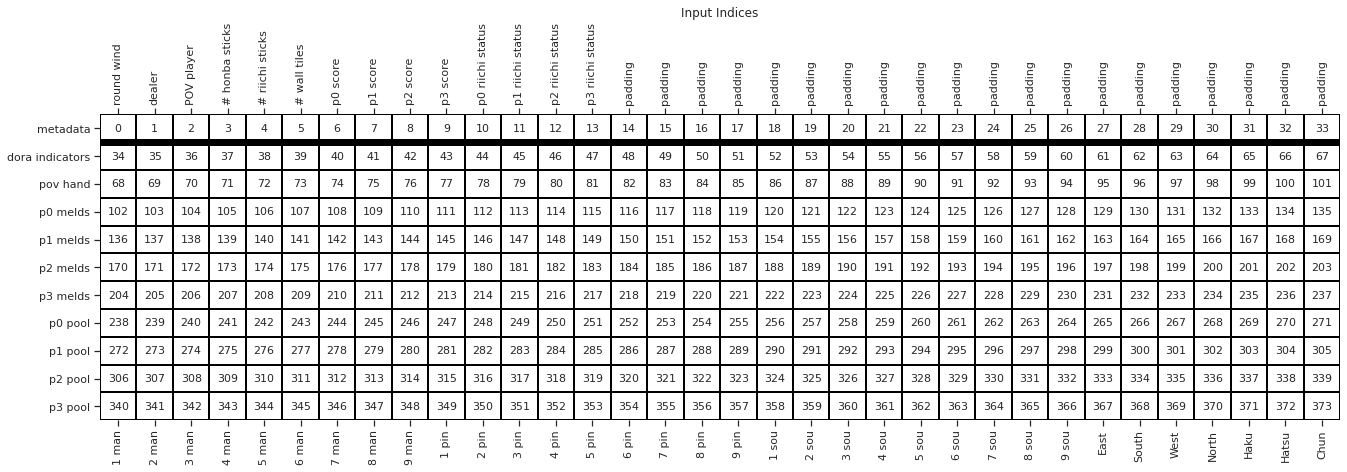

Round Wind       = EAST
Dealer           = EAST
POV Player       = WEST

Honba / Riichi Count = 2 / 0
Wall Tiles left  = 38
Score =	 [ 25000 / 13000 / 43000 / 19000 ]
Riichi Status =	 [0-0-0-0]

Dora Indicators = 5p

POV Hand        = 4889m23456p23667s

P0 Melds        = 
P1 Melds        = 
P2 Melds        = 
P3 Melds        = 111z

P0 Pools        = 8p9s135667z
P1 Pools        = 9m299p28s2z
P2 Pools        = 3s1334456z
P3 Pools        = 111357m47s6z


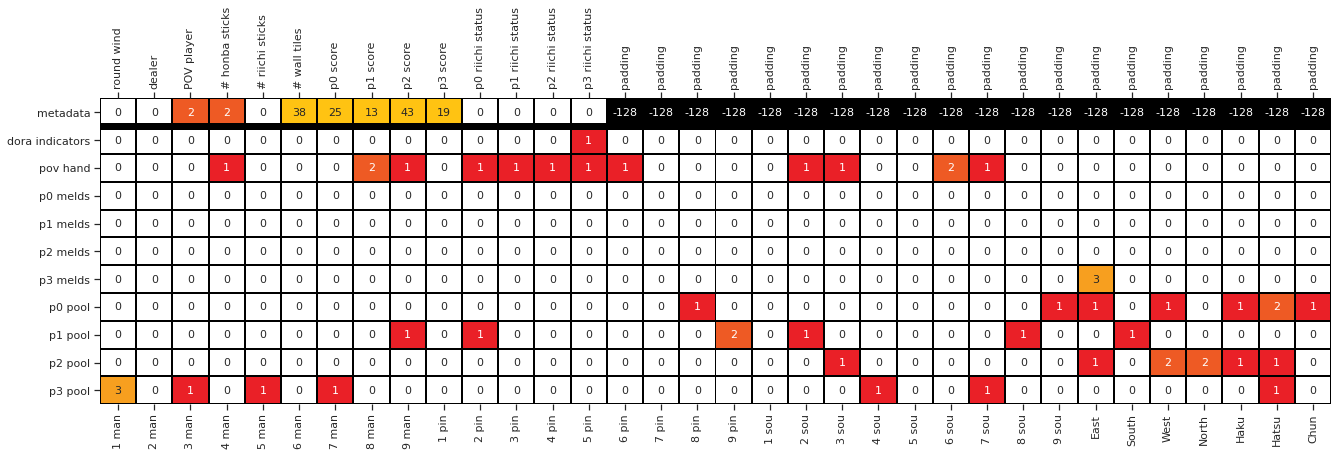

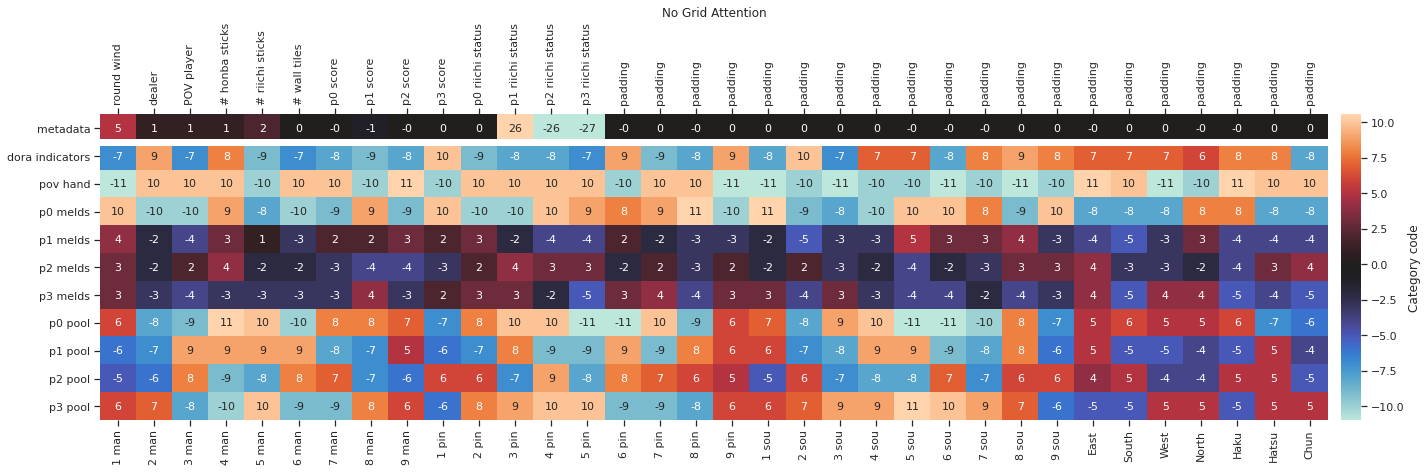

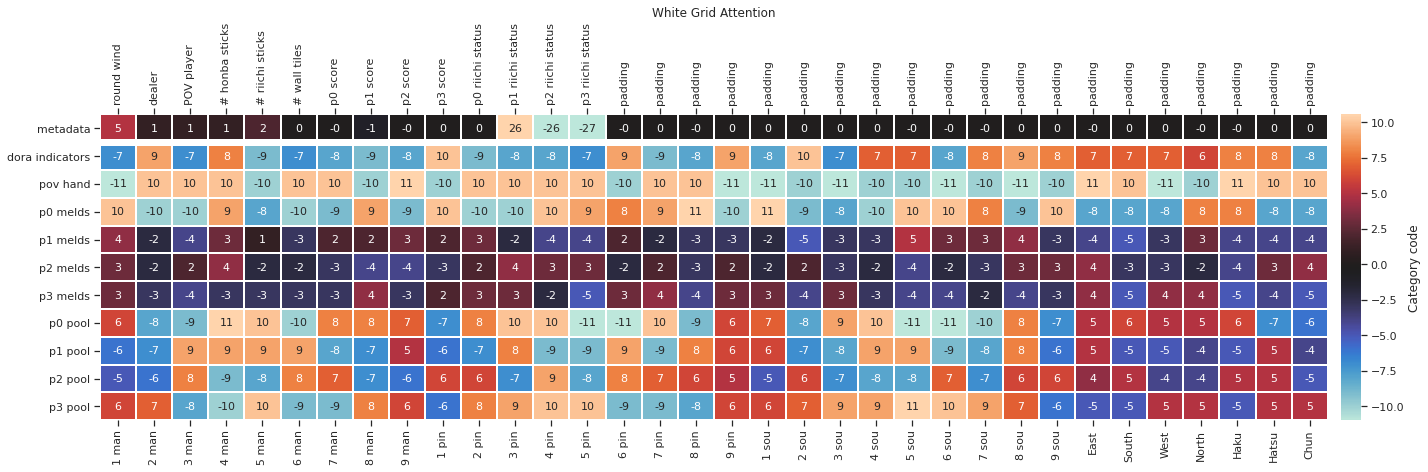

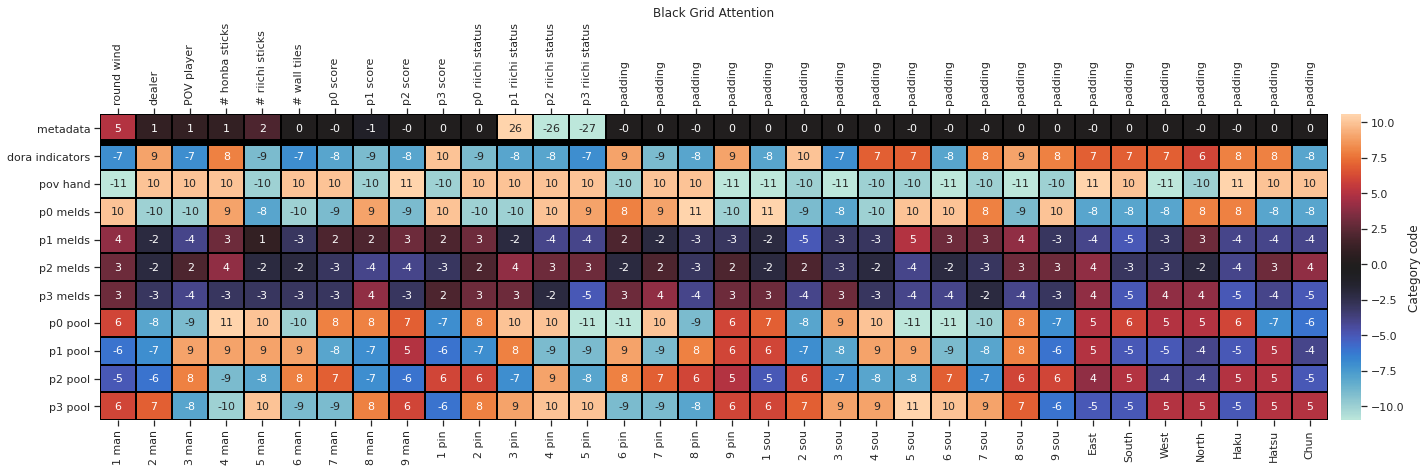

In [580]:
def generate_input_heatmap(input_array: np.array, title=None, cbar=True, color_scheme='white', grid_color='black'):
    
    assert color_scheme in ['white', 'attention', 'plain']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6.5), sharex='col', gridspec_kw={'width_ratios':[120, 2]})  # ax1 = heatmap, ax2 = colormap

    twin1 = ax1.twiny()

    yticklabels=[
        'metadata',
        'dora indicators',
        'pov hand',
        'p0 melds',
        'p1 melds',
        'p2 melds',
        'p3 melds',
        'p0 pool',
        'p1 pool',
        'p2 pool',
        'p3 pool',
    ]
    
    # TODO: Mask for interesting effects?
#     mask = np.zeros((11, 34))
#     mask[0, 5:10] = 1
    
    # Common Params
    heatmap_params = dict(
        ax=ax1,
        annot=True,
        fmt='g',
#         mask=mask,
        square=False,
        xticklabels=ticks_tiles_oneline,
        yticklabels=yticklabels,     
        annot_kws={"fontsize":11},
        robust=True,        
        cbar=True,  # cbar param is always true, but we instead turn it invisible later if cbar is disabled
        cbar_ax=ax2,
        cbar_kws=dict(
            shrink=0.3, 
            label='Category code',
        )
    )
    
    # Extension of Params
    if color_scheme == 'attention':
        heatmap_params.update(dict(
            cmap="icefire",
#             vmin=-10,
#             vmax=10,
        ))
    elif color_scheme == 'plain':
        heatmap_params.update(dict(
            norm=matplotlib.colors.BoundaryNorm([-128, 0, 1, 2, 3, 4, 128], 7),
            cmap=sns.color_palette(["#000000",
                                    "#FFFFFF", 
                                    "#EA2027", 
                                    "#EE5A24", 
                                    "#F79F1F", 
                                    "#FFC312", ])))
    else:
        heatmap_params.update(dict(cmap=sns.color_palette(["#FFFFFF"])))  # All white
        

        
    if grid_color == None:
        linewidths = 0
    else:
        heatmap_params.update(dict(linewidths=1, linecolor=grid_color))
    
    # Heatmap Creation
    ax1 = sns.heatmap(pd.DataFrame(input_array), **heatmap_params)

#     twin1.set_xlabel("Metadata Labels")
    twin1.set_xlim(ax1.get_xlim())
    twin1.set_xticks(ax1.get_xticks())
    metadata_labels = [
        'round wind',
        'dealer',
        'POV player',
        '# honba sticks',
        '# riichi sticks',
        '# wall tiles',
        'p0 score',
        'p1 score',
        'p2 score',
        'p3 score',
        'p0 riichi status',
        'p1 riichi status',
        'p2 riichi status',
        'p3 riichi status',
    ] + ['padding' for _ in range(20)]
    twin1.set_xticklabels(labels=metadata_labels, rotation='vertical')
    
    # Metadata separator line
    ax1.hlines(range(1, 2), -0.5, 34.5, linewidth=7, color=grid_color)  
    
    sns.despine(left=True, bottom=True)
    
    fig.tight_layout()
    
    if title:
        plt.title(title)
    
    if not cbar:
        ax2.set_visible(False)

    plt.show()


# Index Heatmap
generate_input_heatmap(np.arange(0, 374).reshape(11, 34), cbar=False, color_scheme='white', title='Input Indices')


# Validation Heatmaps
model.eval()

n_inputs = 5
x = validation_dataset.x_data[100:105].to(DEVICE)
x = x.reshape(1, x.shape[0], 374)
attn_output, _ = model.mha1(query=x, key=x, value=x, need_weights=None)
attn_output = attn_output.reshape(n_inputs, 374)

for i, attention_values in enumerate(attn_output):
    
    pretty_print_x(x[0, i])

    
    x_arr = x[0, i].cpu().detach().numpy().reshape(11, 34)
    generate_input_heatmap(x_arr, cbar=False, color_scheme='plain')

    
    attention_result = attention_values.reshape(11, 34).cpu().detach().numpy()
    attention_result = np.around(attention_result, decimals=0)
    generate_input_heatmap(attention_result, color_scheme='attention', grid_color=None, title='No Grid Attention')
    generate_input_heatmap(attention_result, color_scheme='attention', grid_color='white', title='White Grid Attention')
    generate_input_heatmap(attention_result, color_scheme='attention', grid_color='black', title='Black Grid Attention')

    
    break # TODO: REMOVE!